In [1]:
%pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [11]:
import warnings 
warnings.filterwarnings('ignore')

In [9]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [5]:
df = pd.read_csv('/kaggle/input/preprocessed-dataset-csv/preprocessed_dataset.csv')
# Define the features and target variable
X = df.drop('isGoal', axis=1)  # Features
y = df['isGoal']  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Display the shapes of the train and test sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
# print("Shape of X_val:", X_val.shape)

print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)
# print("Shape of y_val:", y_val.shape)

Shape of X_train: (266492, 15)
Shape of X_test: (66624, 15)
Shape of y_train: (266492,)
Shape of y_test: (66624,)


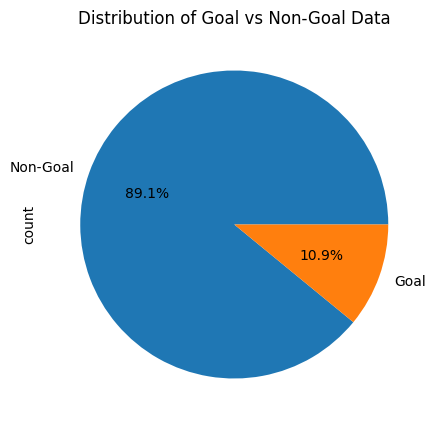

In [12]:
# pie chart for Goal vs Non-Goal Data
plt.figure(figsize=(5, 5))
df['isGoal'].value_counts().rename({1: 'Goal', 0: 'Non-Goal'}).plot.pie(autopct='%1.1f%%')
plt.title("Distribution of Goal vs Non-Goal Data")
plt.show()

We notice that the models lean towards predicting that the shot is not a goal, this might be due to the imbalance of the dataset ( 10.9% of all rows are missed shots )

To counteract this, we can use SMOTE for data augmentation

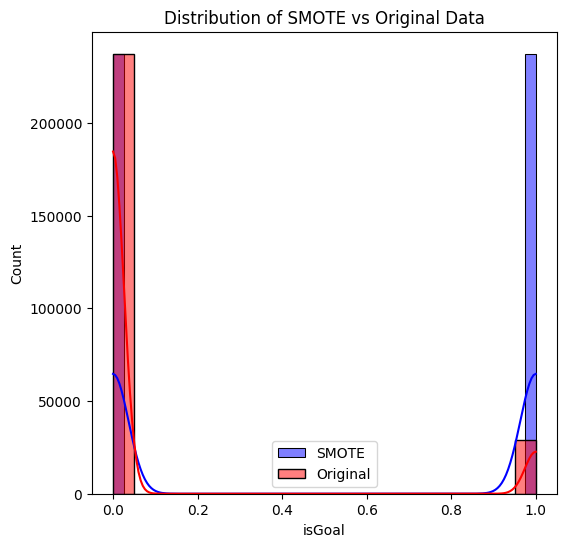

In [13]:
# we now need to balance data so that the goal and non-goal data are closer to each other
# we will use SMOTE to do this
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

#  visualize the data
plt.figure(figsize=(6, 6))
sns.histplot(y_train_smote, color='blue', label='SMOTE', kde=True)
sns.histplot(y_train, color='red', label='Original', kde=True)
plt.legend()
plt.title("Distribution of SMOTE vs Original Data")
plt.show()

In [8]:
params = [
    {
        'Regressor' : [RandomForestRegressor()],
        'Regressor__criterion': ['friedman_mse'],
        'Regressor__n_estimators': [50, 100],
    },
    {
        'Regressor' : [XGBRegressor()],
        'Regressor__learning_rate' : [0.01, 0.1],
        'Regressor__n_estimators' : [50, 100],
        'Regressor__max_depth': [10, 15],
        'Regressor__learning_rate': [0.01, 0.1],
        'Regressor__eval_metric': ['rmse', 'mae'],
    },
    {
        'Regressor' : [CatBoostRegressor()],
        'Regressor__learning_rate' : [0.01, 0.1],
        'Regressor__n_estimators' : [50, 100],
        'Regressor__max_depth': [10, 15],
    },
    {
        'Regressor' : [LogisticRegression()],
        'Regressor__C': [0.001, 0.01, 0.1, 1],
    }    
]

In [80]:
%%time

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

random_state = 0
models = [
   RandomForestRegressor(random_state=random_state),
   XGBRegressor(random_state=random_state),
#    LGBMRegressor(random_state=random_state),
   CatBoostRegressor(random_state=random_state),
   LogisticRegression(),
]

best_params_list = []
mae_list = []

for i, model in enumerate(models):
    print(f"Model {i+1}: {type(model).__name__}")
    
    pipe = Pipeline([('Regressor', model)])
    param_grid = params[i]
    cv = 5
    grid_search = GridSearchCV(pipe, param_grid, cv=cv,scoring='mean_absolute_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # CatBoost handling
    if isinstance(model, CatBoostRegressor):
        best_params_cbr = CatBoostRegressor(verbose=False, random_state=random_state).fit(X_train, y_train).get_params()
        
    else:
        best_params = grid_search.best_params_
        best_params_list.append(best_params)
    
    mae = grid_search.best_score_
    mae_list.append(mae)
    
        
    print("Best parameters:", best_params)
    print("Mean value:",  mae)
    print()

In [12]:
for params_dict in best_params_list:
    params_dict.pop('Regressor', None)

best_params_list

[{'Regressor__criterion': 'friedman_mse', 'Regressor__n_estimators': 100},
 {'Regressor__eval_metric': 'rmse',
  'Regressor__learning_rate': 0.1,
  'Regressor__max_depth': 10,
  'Regressor__min_samples_split': 2,
  'Regressor__n_estimators': 50},
 {'Regressor__learning_rate': 0.1,
  'Regressor__max_depth': 15,
  'Regressor__n_estimators': 100,
  'Regressor__num_leaves': 13},
 {'Regressor__C': 0.1}]

In [83]:
best_params_cbr

{'loss_function': 'RMSE', 'verbose': False, 'random_state': 0}

In [14]:
mae_list

[-0.13868049471958468,
 -0.13363838174205403,
 -0.13470728368989765,
 -0.13424299555693145,
 -0.09245305254979834]

In [14]:
best_params_cbr = {'loss_function': 'RMSE', 'verbose': False, 'random_state': 0}
best_params_list = [
    {
        'Regressor__criterion': 'friedman_mse', 
        'Regressor__n_estimators': 100
    },
    {
        'Regressor__eval_metric': 'rmse',
        'Regressor__learning_rate': 0.1,
        'Regressor__max_depth': 10,
        'Regressor__min_samples_split': 2,
        'Regressor__n_estimators': 50
    },
    {
        'Regressor__learning_rate': 0.1,
        'Regressor__max_depth': 15,
        'Regressor__n_estimators': 100,
        'Regressor__num_leaves': 13},
    {
        'Regressor__C': 0.1
    }
]

In [50]:
def train_models(X, y, models, smote=False):
    test_mse_list = []
    for i, model in enumerate(models):
        if smote:
            print(f"Model SMOTE {i+1}: {type(model).__name__}")
        else:
            print(f"Model {i+1}: {type(model).__name__}")

        # CatBoost handling
        if isinstance(model, CatBoostRegressor):
            model.set_params(**best_params_cbr)  # Set the best parameters for CatBoost
        elif params:
            model_params = {key.split('__')[1]: value for key, value in best_params_list[i].items()}
            model.set_params(**model_params)  # Set the best parameters for other models

        # Train and evaluate the model
        model.fit(X, y)
        y_predict = model.predict(X_test)
        y_pred_binary = [int(round(p)) for p in y_predict]
        test_acc = accuracy_score(y_test, y_pred_binary)
        test_mse = mean_squared_error(y_predict, y_test)
        test_mse_list.append(test_mse) 

        print(f'ACC Score in test dataset: {test_acc*100}%')       
        print(f'MSE Score in test dataset: {test_mse}')

    return models

In [51]:
# testing the models
from sklearn.metrics import accuracy_score

def test_models(models, smote=False):
    preds = {}
    for model in models:
        model_name = type(model).__name__
        # TEST EVAL

        y_pred = model.predict(X_test)
        preds[model_name] = y_pred
        y_pred_binary = [int(round(p)) for p in y_pred]
        acc = accuracy_score(y_test, y_pred_binary)
 
        mse = mean_squared_error(y_test, y_pred)
        if smote:
            print(f"{model_name} Metrics (SMOTE):")
        else:
            print(f"{model_name} Metrics:")
        print(f"  MSE TEST: {mse}")
        print(f'  ACC TEST: {acc*100}%')
        
        # TRAIN EVAL
        y_pred = model.predict(X_train)
        y_pred_binary = [int(round(p)) for p in y_pred]
        acc = accuracy_score(y_train, y_pred_binary)
 
        mse = mean_squared_error(y_train, y_pred)
        print(f"  MSE TRAIN: {mse}")
        print(f'  ACC TRAIN: {acc*100}%')
        
    return preds

## Training the models

In [52]:
%%time
# train models
random_state = 0
models_1 = [
   RandomForestRegressor(random_state=random_state),
   XGBRegressor(random_state=random_state),
   CatBoostRegressor(random_state=random_state),
   LogisticRegression(),
]
models_2 = [
   RandomForestRegressor(random_state=random_state),
   XGBRegressor(random_state=random_state),
   CatBoostRegressor(random_state=random_state),
   LogisticRegression(),
]

test_mse_list = []

models_default = train_models(X_train, y_train, models_1)
models_smote = train_models(X_train_smote, y_train_smote, models_2, smote=True)

Model 1: RandomForestRegressor
ACC Score in test dataset: 90.80211335254563%
MSE Score in test dataset: 0.07087766107247412
Model 2: XGBRegressor
ACC Score in test dataset: 91.18335734870317%
MSE Score in test dataset: 0.06742663208158678
Model 3: CatBoostRegressor
ACC Score in test dataset: 91.23439000960614%
MSE Score in test dataset: 0.0667860552904059
Model 4: LogisticRegression
ACC Score in test dataset: 90.81111911623438%
MSE Score in test dataset: 0.0918888088376561
Model SMOTE 1: RandomForestRegressor
ACC Score in test dataset: 87.78067963496638%
MSE Score in test dataset: 0.09432554181936832
Model SMOTE 2: XGBRegressor
ACC Score in test dataset: 87.64859510086455%
MSE Score in test dataset: 0.0991820094367498
Model SMOTE 3: CatBoostRegressor
ACC Score in test dataset: 88.20695244956772%
MSE Score in test dataset: 0.09378571211680081
Model SMOTE 4: LogisticRegression
ACC Score in test dataset: 86.77203410182517%
MSE Score in test dataset: 0.13227965898174832
CPU times: user 17m

## Testing the models

In [54]:
# test the models
preds_default = test_models(models_default)
print()
preds_smote = test_models(models_smote, smote=True)

RandomForestRegressor Metrics:
  MSE TEST: 0.07087766107247412
  ACC TEST: 90.80211335254563%
  MSE TRAIN: 0.009879039090864992
  ACC TRAIN: 99.97185656605076%
XGBRegressor Metrics:
  MSE TEST: 0.06742663208158678
  ACC TEST: 91.18335734870317%
  MSE TRAIN: 0.055287198294794046
  ACC TRAIN: 93.04932230611051%
CatBoostRegressor Metrics:
  MSE TEST: 0.0667860552904059
  ACC TEST: 91.23439000960614%
  MSE TRAIN: 0.06208056164020229
  ACC TRAIN: 91.961860018312%
LogisticRegression Metrics:
  MSE TEST: 0.0918888088376561
  ACC TEST: 90.81111911623438%
  MSE TRAIN: 0.09204028638758387
  ACC TRAIN: 90.79597136124161%

RandomForestRegressor Metrics (SMOTE):
  MSE TEST: 0.09432554181936832
  ACC TEST: 87.78067963496638%
  MSE TRAIN: 0.011585253621976547
  ACC TRAIN: 99.97335754919472%
XGBRegressor Metrics (SMOTE):
  MSE TEST: 0.0991820094367498
  ACC TEST: 87.64859510086455%
  MSE TRAIN: 0.08969379401678487
  ACC TRAIN: 89.05483091424883%
CatBoostRegressor Metrics (SMOTE):
  MSE TEST: 0.0937857

In [88]:
# visualize the results
import matplotlib.pyplot as plt
import seaborn as sns


def plot_results(preds, models):
    fig, axs = plt.subplots(2, 2, figsize=(18, 12))
    model_names = [type(model).__name__ for model in models]
    for i, model_name in enumerate(model_names):
        row = i // 2
        col = i % 2
        sns.histplot(y_test, label='True', linewidth=1, color='black', linestyle="--", ax=axs[row, col], kde=True)
        y_pred = preds[model_name]
        y_pred_round = [round(y) for y in y_pred]
        y_pred = [max(y, 0) for y in y_pred]

        sns.histplot(y_pred_round, label='Predicted Rounded', linewidth=1, color='yellow', ax=axs[row, col], kde=True)
        sns.histplot(y_pred, label='Predicted', linewidth=1, color='magenta', ax=axs[row, col])
        axs[row, col].axvline(x=1, color='green', linestyle='--', linewidth=1)
        axs[row, col].axvline(x=0, color='green', linestyle='--', linewidth=1)
        axs[row, col].legend()
        mse = mean_squared_error(y_test, preds[model_name])
        acc = accuracy_score(y_test, y_pred_round) * 100
        axs[row, col].set_title(f"Distribution of Predictions for {model_name} (mse: {mse:.3f}, acc:{acc:.2f}%)")

    plt.show()

# Results for fitting models without SMOTE

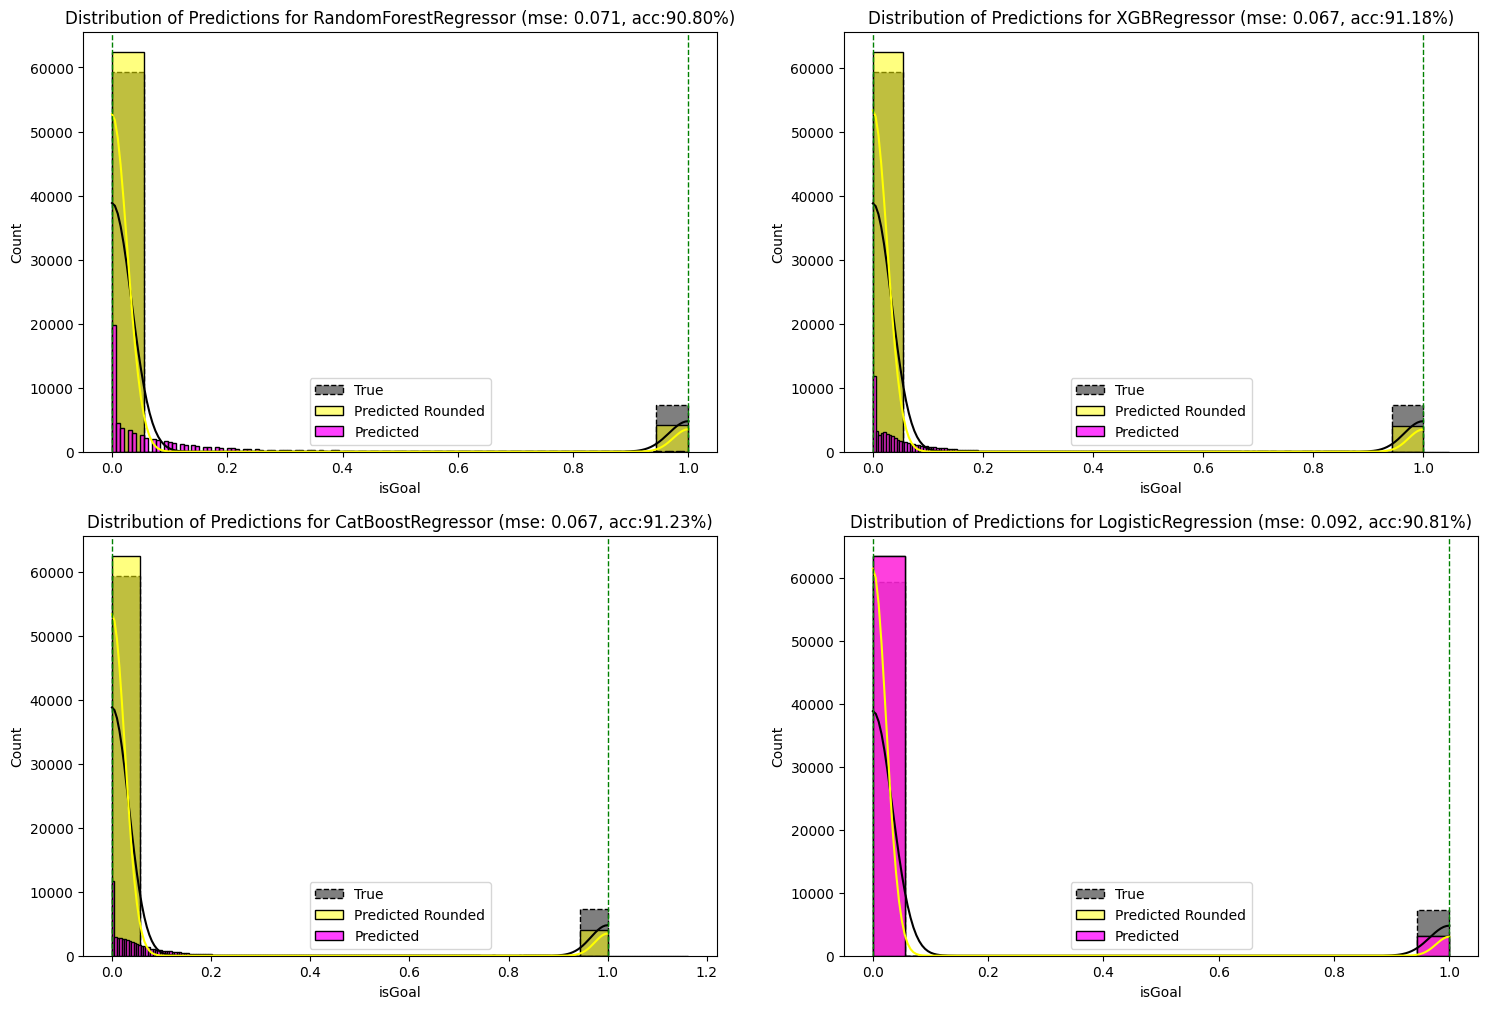

In [89]:
plot_results(preds_default, models_default)

We notice that the models lean towards predicting that the shot is not a goal, this might be due to the imbalance of the dataset ( 10.9% of all rows are missed shots )

# Results for fitting models with SMOTE

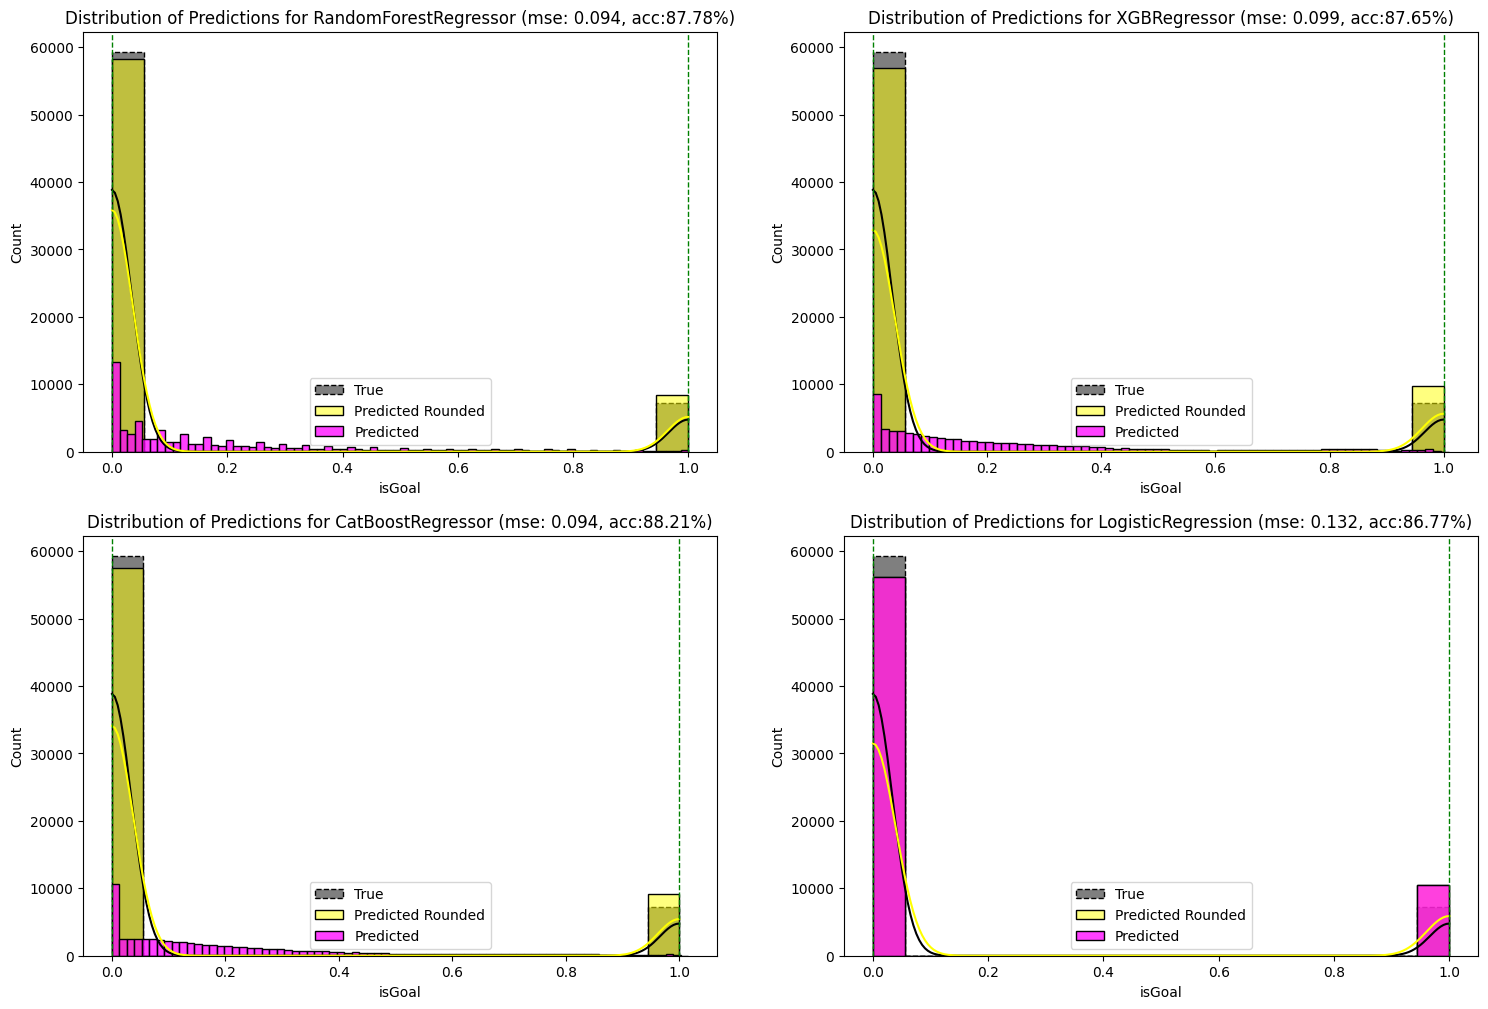

In [90]:
plot_results(preds_smote, models_default)

In [96]:
for model in models_default:
    preds = model.predict(X)
    pred_round = [round(pred) for pred in preds]
    accuracy = accuracy_score(y, pred_round)
    mse = mean_squared_error(y, pred_round)
    print(f"{type(model)} SMOTE Metrics:")
    print(f"\tAccuracy: {accuracy}")
    print(f"\tMSE: {mse}")
    print("\n")
  

<class 'sklearn.ensemble._forest.RandomForestRegressor'> SMOTE Metrics:
	Accuracy: 0.9813788590160785
	MSE: 0.01862114098392152


<class 'xgboost.sklearn.XGBRegressor'> SMOTE Metrics:
	Accuracy: 0.9267612483339137
	MSE: 0.07323875166608629


<class 'catboost.core.CatBoostRegressor'> SMOTE Metrics:
	Accuracy: 0.9181636426950371
	MSE: 0.08183635730496283


<class 'sklearn.linear_model._logistic.LogisticRegression'> SMOTE Metrics:
	Accuracy: 0.907990009486185
	MSE: 0.092009990513815




In [95]:
for model in models_smote:
    preds = model.predict(X)
    pred_round = [round(pred) for pred in preds]
    accuracy = accuracy_score(y, pred_round)
    mse = mean_squared_error(y, pred_round)
    print(f"{type(model)} SMOTE Metrics:")
    print(f"\tAccuracy: {accuracy}")
    print(f"\tMSE: {mse}")
    print("\n")
  

<class 'sklearn.ensemble._forest.RandomForestRegressor'> SMOTE Metrics:
	Accuracy: 0.9753479268483051
	MSE: 0.024652073151694907


<class 'xgboost.sklearn.XGBRegressor'> SMOTE Metrics:
	Accuracy: 0.8877358037440412
	MSE: 0.11226419625595889


<class 'catboost.core.CatBoostRegressor'> SMOTE Metrics:
	Accuracy: 0.8852291694184609
	MSE: 0.11477083058153917


<class 'sklearn.linear_model._logistic.LogisticRegression'> SMOTE Metrics:
	Accuracy: 0.8691927136492994
	MSE: 0.13080728635070066


